In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import matplotlib as mpl

In [8]:
from tensorflow.keras.datasets import cifar10
(x_train_set, y_train_set), (x_test, y_test)=cifar10.load_data()


Data

In [9]:
x_train_set = x_train_set / 255.0
x_test = x_test / 255.0
#讓資料介於0~1之間

(check data)

In [10]:
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

[9]


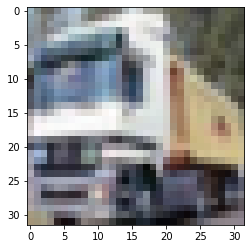

In [12]:
i = 1
print(y_train_set[i])
plt.imshow(x_train_set[i]) #, cmap='binary')
plt.show()

**Split data**

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_set, y_train_set) #, random_state=1)

**Stacked Autoencoder**
1. Build model

In [15]:
tf.random.set_seed(1)
np.random.seed(1)

In [71]:
sk_encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32,32,3]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
sk_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(32 * 32 * 3, activation='sigmoid'),
    keras.layers.Reshape([32,32,3])
])
sk_ae = keras.models.Sequential([sk_encoder, sk_decoder])

In [72]:
sk_encoder.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 3072)              0         
                                                                 
 dense_36 (Dense)            (None, 100)               307300    
                                                                 
 dense_37 (Dense)            (None, 30)                3030      
                                                                 
Total params: 310,330
Trainable params: 310,330
Non-trainable params: 0
_________________________________________________________________


In [73]:
sk_decoder.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 100)               3100      
                                                                 
 dense_39 (Dense)            (None, 3072)              310272    
                                                                 
 reshape_9 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
Total params: 313,372
Trainable params: 313,372
Non-trainable params: 0
_________________________________________________________________


In [74]:
sk_ae.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 30)                310330    
                                                                 
 sequential_26 (Sequential)  (None, 32, 32, 3)         313372    
                                                                 
Total params: 623,702
Trainable params: 623,702
Non-trainable params: 0
_________________________________________________________________


2. Compile

In [75]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [76]:
sk_ae.compile(loss='binary_crossentropy',
      optimizer = keras.optimizers.SGD(learning_rate=1.5),
      metrics=[rounded_accuracy])

3. Train

In [77]:
train = sk_ae.fit(x_train, x_train,
          epochs=20,
          validation_data=(x_valid, x_valid))
#注意這邊的y_train式放入x_train，是因為這個模型最後產出的值會跟一開始的資料比較。

Epoch 1/20
1172/1172 [==============================] - 20s 16ms/step - loss: 0.6447 - rounded_accuracy: 0.7072 - val_loss: 0.6208 - val_rounded_accuracy: 0.7719
Epoch 2/20
1172/1172 [==============================] - 18s 16ms/step - loss: 0.6148 - rounded_accuracy: 0.7870 - val_loss: 0.6105 - val_rounded_accuracy: 0.7919
Epoch 3/20
1172/1172 [==============================] - 20s 17ms/step - loss: 0.6058 - rounded_accuracy: 0.8068 - val_loss: 0.6015 - val_rounded_accuracy: 0.8163
Epoch 4/20
1172/1172 [==============================] - 20s 17ms/step - loss: 0.6002 - rounded_accuracy: 0.8195 - val_loss: 0.6000 - val_rounded_accuracy: 0.8191
Epoch 5/20
1172/1172 [==============================] - 19s 16ms/step - loss: 0.5968 - rounded_accuracy: 0.8279 - val_loss: 0.5950 - val_rounded_accuracy: 0.8341
Epoch 6/20
1172/1172 [==============================] - 19s 16ms/step - loss: 0.5945 - rounded_accuracy: 0.8335 - val_loss: 0.6008 - val_rounded_accuracy: 0.8203
Epoch 7/20
1172/1172 [======

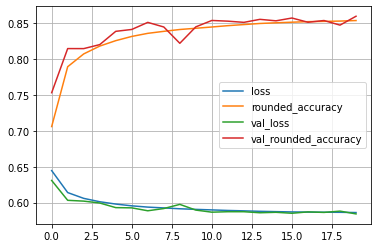

In [50]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

4.Evaluate


In [51]:
sk_ae.evaluate(x_test, x_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.5849 - rounded_accuracy: 0.8592


[0.5848637819290161, 0.8591726422309875]

5. Predict(Reconstruct)

In [52]:
x_test_decoded = sk_ae.predict(x_test)

313/313 [==============================] - 1s 4ms/step


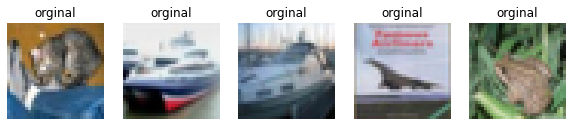

In [81]:
plt.figure(figsize=(10,4))
for i in range(5):
  plt.subplot(2, 5, 1+i)
  plt.imshow(x_test[i], cmap='binary')
  plt.title('orginal')
  plt.axis('off')

  '''plt.subplot(2, 5, 1+5+i)
  plt.imshow(x_test_decoded[i], cmap='binary')
  plt.title('reconstructed')
  plt.axis('off')'''
plt.show()

(Check codings)

In [78]:
x_test_codings = sk_encoder.predict(x_test)
x_test_codings.shape

313/313 [==============================] - 1s 2ms/step


(10000, 30)

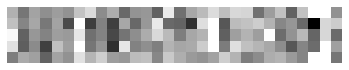

In [79]:
i = range(5)

plt.imshow(x_test_codings[i], cmap='binary')
plt.axis('off')
plt.show()

**Application: Data Visualization**

In [82]:
#視覺化降維
from sklearn.manifold import TSNE

np.random.seed(1)

tsne = TSNE()
x_test_2D = tsne.fit_transform(x_test_codings)

x_test_2D = (x_test_2D - x_test_2D.min()) / (x_test_2D.max()-x_test_2D.min())

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [83]:
x_test_2D.shape

(10000, 2)

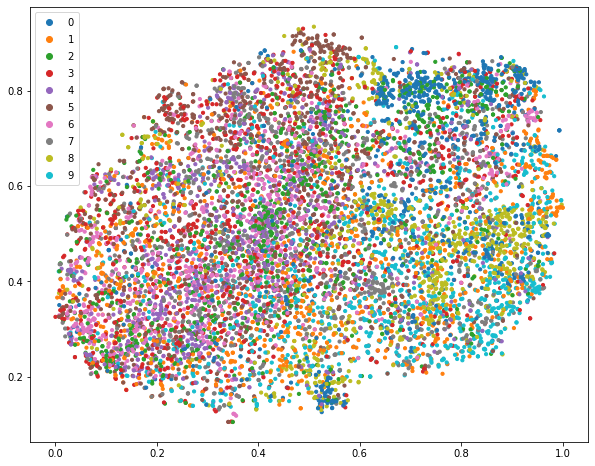

In [84]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(x_test_2D[:,0], x_test_2D[:,1], c=y_test, s=10,
            cmap=plt.cm.tab10)
#c是color，表示用y_test的資料上色；s是點的大小。
plt.legend(*scatter.legend_elements())
plt.show()

ValueError: ignored

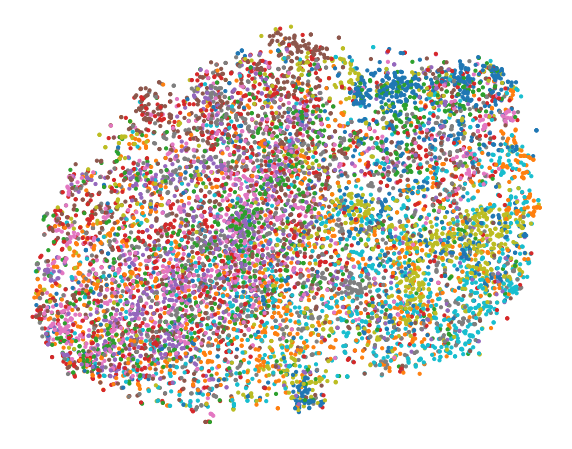

In [85]:
plt.figure(figsize=(10,8))
plt.scatter(x_test_2D[:,0], x_test_2D[:,1], c=y_test, s=10, cmap=plt.cm.tab10)
plt.axis('off')

image_positions = np.array([[1.,1.]])
for index, position in enumerate(x_test_2D):
  dist = np.sum((position - image_positions) ** 2, axis=1)
  if np.min(dist) > 0.02:
    image_positions = np.r_[image_positions, [position]]
    imagebox = mpl.offsetbox.AnnotationBbox(
        mpl.offsetbox.OffsetImage(x_test[index], cmap='binary'),
        position,
        bboxprops={'edgecolor':plt.cm.tab10(y_test[index]), 'lw':2})
    plt.gca().add_artist(imagebox)

plt.show()